In [ ]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torch.nn as nn
from torch.autograd import Variable


class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()

        assert hidden_channels % 2 == 0

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size

        self.padding = int((kernel_size - 1) / 2)

        self.Wxi = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Uhi = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxf = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Uhf = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxc = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Uhc = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxo = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Uho = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)

        self.Vi = None
        self.Vf = None
        self.Vo = None

    def forward(self, x, h, c):
        it = torch.sigmoid(self.Wxi(x) + self.Uhi(h) + c * self.Vi)
        ft = torch.sigmoid(self.Wxf(x) + self.Uhf(h) + c * self.Vf)
        ct = ft * c + it * torch.tanh(self.Wxc(x) + self.Uhc(h))
        ot = torch.sigmoid(self.Wxo(x) + self.Uho(h) + ct * self.Vo)
        ht = ot * torch.tanh(ct)
        return ht, ct

    def init_hidden(self, batch_size, hidden, shape):
        if self.Vi is None:
            self.Vi = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
            self.Vf = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
            self.Vo = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
        else:
            assert shape[0] == self.Vi.size()[2], 'Input Height Mismatched!'
            assert shape[1] == self.Vi.size()[3], 'Input Width Mismatched!'
        return (Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).to(device),
                Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).to(device))


class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_sizes, step=1):
        super(ConvLSTM, self).__init__()
        self.input_channels = [input_channels] + hidden_channels[:-1]
        self.hidden_channels = hidden_channels
        self.kernel_sizes = kernel_sizes
        self.step = step

        assert len(self.input_channels) == len(self.hidden_channels) == len(self.kernel_sizes) == self.step

        self.relu_layer = nn.ReLU(inplace=False)
        self.sigmoid_layer = nn.Sigmoid()
        self.conv_last = nn.Conv2d(self.hidden_channels[-1], 1, kernel_size=3, stride=1, padding=1)
        for i in range(self.step):
            cell = ConvLSTMCell(self.input_channels[i], self.hidden_channels[i], self.kernel_sizes[i])
            setattr(self, 'cell{}'.format(i), cell)
            setattr(self, 'batchN{}'.format(i), nn.BatchNorm2d(hidden_channels[i]))

    def forward(self, input):
      outputs = []
      for seq in range(input.shape[1]):
        x = input[:, seq, ...].permute(0, 3, 1, 2)
        for i in range(self.step):
          
          name = 'cell{}'.format(i)
          
          if seq == 0:
            bsize, _, height, width = x.size()
            (h, c) = getattr(self, name).init_hidden(batch_size=bsize, hidden=self.hidden_channels[i],
                                                    shape=(height, width))


          if seq != 0:
            h, c = getattr(self, 'h_{}_{}'.format(seq-1, i)), getattr(self, 'c_{}_{}'.format(seq-1, i))
          new_h, new_c = getattr(self, name)(x.float(), h.float(), c.float())
          x = new_h
          x = self.relu_layer(x)
          x = getattr(self, 'batchN{}'.format(i))(x)
          setattr(self, 'h_{}_{}'.format(seq, i), new_h)
          setattr(self, 'c_{}_{}'.format(seq, i), new_c)

        x = self.conv_last(x)
        x = self.sigmoid_layer(x)
        outputs.append(x)

      return outputs

In [ ]:
from matplotlib.legend import StepPatch


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, step, dropout_prob):
        super(DownBlock, self).__init__()
        channelsList = step*[out_channels[-1]]
        self.convlstm = ConvLSTM(in_channels, channelsList, step=step, dropout_prob=dropout_prob)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.convlstm(x)
        down_out = self.down_sample(skip_out)
        return down_out, skip_out


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, step, dropout_prob):
        super(UpBlock, self).__init__()
        channelsList = step*[out_channels[-1]]
        self.up_sample = nn.ConvTranspose2d(in_channels - out_channels[0], in_channels - out_channels[0], kernel_size=2,
                                            stride=2)
        self.convlstm = ConvLSTM(in_channels, channelsList, step=step, dropout_prob=dropout_prob)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.convlstm(x)


class UNet(nn.Module):
    def __init__(self, out_classes=1, filterList=[1, 64], step=3, dropout_prob=0.4):
        super(UNet, self).__init__()
        self.filterSize = len(filterList)

        """# Downsampling Path
        for i in range(1, len(filterList)-1):
          name = 'down_conv{}'.format(i)
          outListDown = []
          for _ in range(step):
            outListDown.append(filterList[i])
          setattr(self, name, DownBlock(filterList[i-1], outListDown, step, dropout_prob))"""


        # Bottleneck
        bottleList = step*[filterList[-1]]
        self.convlstm = ConvLSTM(filterList[-2], bottleList, kernel_sizes=[5, 3, 1], step=step)

        """# Upsampling Path
        for i in range(len(filterList)-2, 0, -1):
          name = 'up_conv{}'.format(i)
          outListUp = []
          for _ in range(step):
            outListUp.append(filterList[i])
          setattr(self, name, UpBlock(filterList[i] + filterList[i+1], outListUp, step, dropout_prob))"""

        # Final Convolution
        # self.conv_last = nn.Conv2d(filterList[-1], out_classes, kernel_size=3, stride=1, padding=1)
        # self.sigmoid_layer = nn.Sigmoid()

    def forward(self, x):
        """for i in range(1, self.filterSize-1):
          x, skip_out = getattr(self, 'down_conv{}'.format(i))(x)
          setattr(self, 'skip_out{}'.format(i), skip_out)"""

        x = self.convlstm(x)

        """for i in range(self.filterSize-2, 0, -1):
          x = getattr(self, 'up_conv{}'.format(i))(x, getattr(self, 'skip_out{}'.format(i)))"""

        # x = self.conv_last(x)
        # x = self.sigmoid_layer(x)
        # x = [ (Nb, 1, Ny, Nx), (Nb, 1, Ny, Nx), ...]
        x = torch.cat(x, dim=1)

        return x

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :, :]
    y = data[:, 1 : data.shape[1], :, :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


In [ ]:
from torch.utils.data import Dataset

class DataClass(Dataset):

    def __init__(self, a, b):
        self.imgs = a
        self.label = b

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx], self.label[idx]

In [ ]:
from torch.utils.data import random_split

def get_dataloaders(train_dataset, val_dataset, dataloader_workers: int = 2, batch_size: int = 8):
    
    kwargs = {'pin_memory': True, 'num_workers': dataloader_workers}
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        **kwargs
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        drop_last=False,
        shuffle=False,
        **kwargs
    )
    return {'train': train_loader, 'val': val_loader}

In [ ]:
def calc_loss(target, pred, loss_fn):
    loss = loss_fn(pred, target)
    return loss

In [ ]:
def plot_training(total_loss):
    plt.plot(total_loss["train"], color='blue')
    plt.title("Loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(total_loss["val"], color='red')
    plt.legend(['train_loss', 'val_loss'])
    plt.show()

## Model Construction

To build a Convolutional LSTM model, we will use the
`ConvLSTM2D` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
from tqdm import tqdm
from torchmetrics import Accuracy, F1Score, Precision, Recall, MetricCollection


def train_model(model, dataloaders, use_cuda, epochs, optimizer, checkpoint_path_model = "/content/current_best_do.pth", checkpoint_path_model_train = "/content/train_current_best.pth", trained_epochs: int = 0, tb_writer = None):
    best_loss = 1e10
    best_loss2 = 1e10
    total_acc = {key: [] for key in ['train', 'val']}
    total_loss = {key: [] for key in ['train', 'val']}
    loss_fn = nn.BCELoss().to(device)
    optimizer = optimizer
    since = time.time()

    metrics = MetricCollection([])

    train_metrics = metrics.clone(prefix="train")
    val_metrics = metrics.clone(prefix="val")

    # iterate over all epochs
    for epoch in range(trained_epochs, epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0
            checking = 0
            for dic in tqdm(dataloaders[phase], total=len(dataloaders[phase])):
                inputs, labels = dic
                labels = labels.reshape([labels.shape[0], labels.shape[1], labels.shape[2], labels.shape[3]])

                if use_cuda:
                    inputs = inputs.to('cuda', dtype=torch.float)  # [batch_size, in_channels, H, W]
                    labels = labels.to('cuda', dtype=torch.float)
                
                checking += 1
                
                optimizer.zero_grad()  # zero the parameter gradients

                # forward pass: compute prediction and the loss btw prediction and true label
                # track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if checking == len(dataloaders[phase])-1 and phase == 'train':
                      save_label_img = labels.cpu().detach().numpy()
                      save_input_img = inputs.cpu().detach().numpy()
                      save_out_img = outputs.cpu().detach().numpy()
                    
                    # output is binary [batch size, n_classes, H, W], target is class [batch size, 1, H, W]
                    loss = calc_loss(labels, outputs, loss_fn)

                    # backward + optimize only if in training phase (no need for torch.no_grad in this training pass)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss * outputs.size(0)
                preds_cpu = outputs.cpu()
                labels_cpu = labels.cpu()
                if phase == "train":
                    train_metrics.update(preds_cpu, labels_cpu)
                elif phase == "val":
                    val_metrics.update(preds_cpu, labels_cpu)

            if phase == "train":
                computed_metrics = train_metrics.compute()
                train_metrics.reset()
            elif phase == "val":
                computed_metrics = val_metrics.compute()
                val_metrics.reset()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            computed_metrics[f"{phase}Loss"] = epoch_loss

            epoch_summary = f'Epoch {phase} : {epoch+1}'
            for k, v in computed_metrics.items():
              epoch_summary = f"{epoch_summary}\n\t{k} : {v:.6f}"

            print(epoch_summary)
            total_loss[phase].append(computed_metrics[f"{phase}Loss"].item())

        
            # Display metrics in Tensorboard
            if tb_writer is not None:
                for item in ["Loss"]:
                    tb_writer.add_scalar(f"{item}/{phase}", computed_metrics[f"{phase}{item}"], epoch)

            # save the model weights in validation phase 
            if phase == 'val':
                if epoch_loss < best_loss:
                    print(f"saving best model to {checkpoint_path_model}")
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), checkpoint_path_model)
            if phase == 'train':
                if epoch_loss < best_loss2:
                    print(f"saving best model to {checkpoint_path_model_train}")
                    best_loss2 = epoch_loss
                    torch.save(model.state_dict(), checkpoint_path_model_train)

        # Display total time
        time_elapsed = time.time() - since
        print('Total time elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    plot_training(total_loss)

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path_model))

    return model, save_input_img, save_label_img, save_out_img

Epoch 1/20
----------


100%|██████████| 225/225 [02:36<00:00,  1.44it/s]


Epoch train : 1
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.170286
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


Epoch val : 1
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.420255
saving best model to /content/current_best.pth
Total time elapsed: 2m 43s
Epoch 2/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 2
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.074460
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Epoch val : 2
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.116760
saving best model to /content/current_best.pth
Total time elapsed: 5m 28s
Epoch 3/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 3
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.070878
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Epoch val : 3
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.208430
Total time elapsed: 8m 13s
Epoch 4/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 4
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.068856
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.87it/s]


Epoch val : 4
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.134474
Total time elapsed: 10m 58s
Epoch 5/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 5
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.067619
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Epoch val : 5
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.192199
Total time elapsed: 13m 43s
Epoch 6/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 6
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.066661
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Epoch val : 6
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.219509
Total time elapsed: 16m 28s
Epoch 7/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 7
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.065845
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Epoch val : 7
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.350056
Total time elapsed: 19m 13s
Epoch 8/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 8
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.065141
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.84it/s]


Epoch val : 8
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.273394
Total time elapsed: 21m 57s
Epoch 9/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 9
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.064568
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Epoch val : 9
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.263919
Total time elapsed: 24m 43s
Epoch 10/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 10
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.063997
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Epoch val : 10
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.188934
Total time elapsed: 27m 28s
Epoch 11/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 11
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.063555
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.87it/s]


Epoch val : 11
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.258777
Total time elapsed: 30m 13s
Epoch 12/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 12
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.063052
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Epoch val : 12
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.314464
Total time elapsed: 32m 58s
Epoch 13/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 13
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.062570
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Epoch val : 13
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.377559
Total time elapsed: 35m 43s
Epoch 14/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 14
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.062203
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Epoch val : 14
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.223182
Total time elapsed: 38m 28s
Epoch 15/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 15
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.061843
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Epoch val : 15
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.116922
Total time elapsed: 41m 14s
Epoch 16/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 16
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.061521
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Epoch val : 16
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.117411
Total time elapsed: 43m 59s
Epoch 17/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 17
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.061170
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Epoch val : 17
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.090379
saving best model to /content/current_best.pth
Total time elapsed: 46m 44s
Epoch 18/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 18
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.060915
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Epoch val : 18
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.067231
saving best model to /content/current_best.pth
Total time elapsed: 49m 29s
Epoch 19/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 19
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.060722
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Epoch val : 19
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.065576
saving best model to /content/current_best.pth
Total time elapsed: 52m 14s
Epoch 20/20
----------


100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Epoch train : 20
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.060585
saving best model to /content/train_current_best.pth


100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Epoch val : 20
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.064656
saving best model to /content/current_best.pth
Total time elapsed: 54m 60s
Best val loss: 0.064656


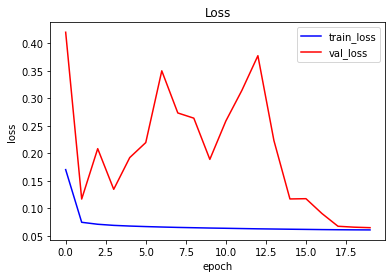

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 4
learning_rate = 1e-3
weight_decay = 1e-5
no_of_seq = 19
model2 = UNet(filterList=[1, 64], step=3, dropout_prob=0.0, out_classes=no_of_seq)
model2 = model2.to(device, dtype=torch.float)
data_train = DataClass(x_train[:, :no_of_seq, :, :], y_train[:, :no_of_seq, :, :])
data_val = DataClass(x_val[:, :no_of_seq, :, :], y_val[:, :no_of_seq, :, :])
dataloaders = get_dataloaders(data_train, data_val, batch_size=batch_size)
optimizer = torch.optim.Adam(params=model2.parameters(), lr=learning_rate, weight_decay=weight_decay)


# Fit the model to the training data.
_, input_img, label_img, out_img = train_model(
    model2,
    dataloaders,
    torch.cuda.is_available(),
    epochs=epochs,
    optimizer=optimizer,
    checkpoint_path_model = "/content/current_best.pth",
    checkpoint_path_model_train = "/content/train_current_best.pth"
)

## Model Training

With our model and data constructed, we can now train the model.

In [ ]:
print(model2)

UNet(
  (convlstm): ConvLSTM(
    (relu_layer): ReLU()
    (sigmoid_layer): Sigmoid()
    (conv_last): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (cell0): ConvLSTMCell(
      (Wxi): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (Uhi): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (Wxf): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (Uhf): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (Wxc): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (Uhc): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (Wxo): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (Uho): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    )
    (batchN0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cell1): ConvLSTMCell(
 

(4, 10, 64, 64) (4, 10, 64, 64, 1) (4, 10, 64, 64)


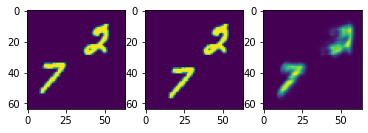

In [ ]:
print(label_img.shape, input_img.shape, out_img.shape)
fig, ax = plt.subplots(1,3)
ax[0].imshow(label_img[2, 9])
ax[1].imshow(input_img[2, 8])
ax[2].imshow(out_img[2, 9])

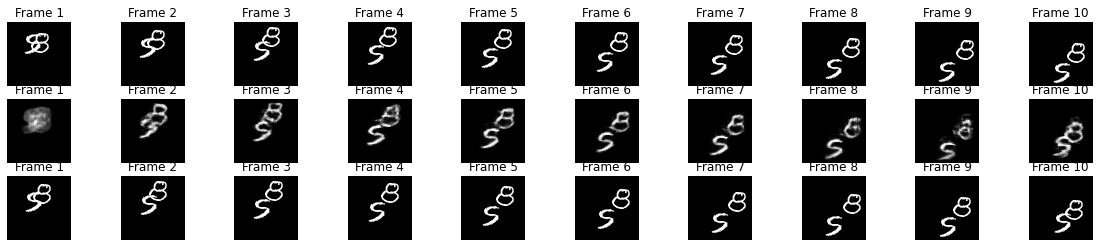

In [ ]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(3, 10, figsize=(20, 4))


# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(input_img[2, idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")


# Plot the original frames.
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(out_img[2, idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")



    # Plot the original frames.
for idx, ax in enumerate(axes[2]):
    ax.imshow(np.squeeze(label_img[2, idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

## Frame Prediction Visualizations

With our model now constructed and trained, we can generate
some example frame predictions based on a new video.

We'll pick a random example from the validation set and
then choose the first ten frames from them. From there, we can
allow the model to predict 10 new frames, which we can compare
to the ground truth frame predictions.

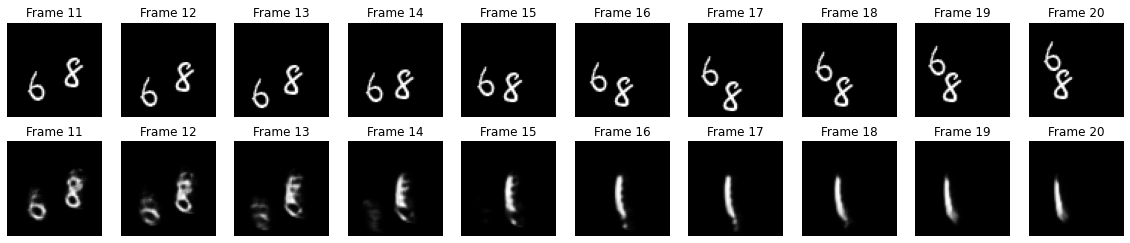

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

seq_len = 10
# Pick the first/last ten frames from the example.
frames = example[:seq_len, ...] # np.transpose(example[:4, ...], (0, 3, 1, 2))
original_frames = example[seq_len:, ...]

# Predict a new set of 10 frames.
model2.load_state_dict(torch.load("/content/current_best.pth"))
model2.eval()
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = (model2(torch.tensor(np.expand_dims(frames, axis=0)).to(device))).cpu().detach().numpy()
    new_prediction = np.squeeze(new_prediction, axis=0)

    # fig, axes = plt.subplots(2, seq_len, figsize=(20, 4))

    # for idx, ax in enumerate(axes[0]):
    #     ax.imshow(np.squeeze(frames[idx]), cmap="gray")
    #     ax.set_title(f"Frame {idx + seq_len + 1}")
    #     ax.axis("off")


    # for idx, ax in enumerate(axes[1]):
    #     ax.imshow(np.squeeze(new_prediction[idx]), cmap="gray")
    #     ax.set_title(f"Frame {idx + seq_len + 1}")
    #     ax.axis("off")

    # # Display the figure.
    # plt.show()

    # break
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    predicted_frame = np.expand_dims(predicted_frame, axis=-1)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, seq_len, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + seq_len + 1}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[seq_len:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + seq_len + 1}")
    ax.axis("off")

# Display the figure.
plt.show()